In [1]:
from UltraFlow import commons
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from openbabel import pybel
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [14]:
lig_path_sdf = r'D:\jiaxianyan\soft\github\UltraFlow\UltraFlow\data\chembl\P49841\visualize_dir\total_vs.sdf'
m_ligs = pybel.readfile('sdf', lig_path_sdf)
name = 'P49841'
dataset_path = r'D:\jiaxianyan\soft\github\UltraFlow\UltraFlow\data\chembl'
ligcut = 5.0
protcut = 30
prot_graph_type = 'residue_complete'
n_jobs = 8
lig_max_neighbors = None
prot_max_neighbors = 10

In [17]:
valid_lig_coords_list, valid_lig_features_list, valid_lig_edges, valid_lig_node_type, valid_index = commons.read_ligands(name, dataset_path, ligcut, lig_type='openbabel')

In [8]:
prot_coords_valid, prot_features_valid, prot_edges, prot_node_type, sec_features, alpha_c_coords, c_coords, n_coords =  commons.read_proteins(name, dataset_path, prot_graph_type, protcut)

@> 5505 atoms and 1 coordinate set(s) were parsed in 0.06s.


In [11]:
lig_graphs = commons.pmap_multi(commons.get_lig_graph_equibind,
                                        zip(valid_lig_coords_list, valid_lig_features_list, valid_lig_node_type),
                                        max_neighbors=lig_max_neighbors, cutoff=ligcut,
                                        n_jobs=n_jobs, desc='Get ligand graphs')

Get ligand graphs: 0it [00:00, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Get ligand graphs: 24it [00:12,  1.95it/s][Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.8s
Get ligand graphs: 1613it [00:15, 105.37it/s]
[Parallel(n_jobs=8)]: Done 1500 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 1613 out of 1613 | elapsed:   15.6s finished


In [15]:
prot_graphs = commons.pmap_multi(commons.get_prot_alpha_c_graph_equibind,
                                 zip([prot_coords_valid], [prot_features_valid], [prot_node_type], [sec_features], [alpha_c_coords], [c_coords], [n_coords]),
                                 n_jobs=n_jobs, cutoff=protcut, max_neighbor=prot_max_neighbors,
                                 desc='Get protein alpha carbon graphs')

Get protein alpha carbon graphs: 0it [00:00, ?it/s][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Get protein alpha carbon graphs: 1it [00:00, 1002.70it/s]
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.1s finished


In [18]:
prot_coords_list, graph_prot_index = [], []
index = 0
for prot_coord, valid_i in zip([prot_coords_valid], [valid_index]):
    prot_coords_list.extend([prot_coord] * len(valid_i))
    graph_prot_index.extend([index] * len(valid_i))
    index += 1

In [20]:
from rdkit.Chem.Scaffolds import MurckoScaffold

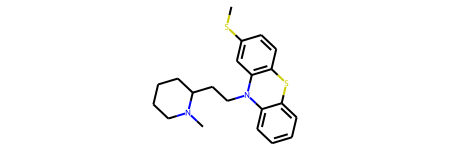

CN1CCCCC1CCN2C3=CC=CC=C3SC4=C2C=C(C=C4)SC


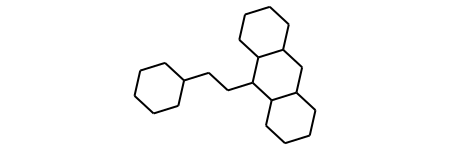

C1CCC(CCC2C3CCCCC3CC3CCCCC32)CC1


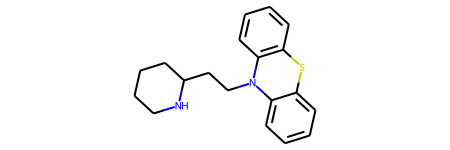

In [26]:
smiles = "CN1CCCCC1CCN2C3=CC=CC=C3SC4=C2C=C(C=C4)SC"
# convert SMILES string to RDKit mol object
mol = Chem.MolFromSmiles(smiles)
# create RDKit mol object corresponding to Bemis-Murcko scaffold of original compound
mol_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
# make the scaffold generic by replacing all atoms with carbons and all bonds with single bonds
mol_scaffold_generic = MurckoScaffold.MakeScaffoldGeneric(mol_scaffold)
# convert the generic scaffold mol object back to a SMILES string format
smiles_scaffold_generic = Chem.CanonSmiles(Chem.MolToSmiles(mol_scaffold_generic))
# display compound and its generic Bemis-Murcko scaffold
display(mol)
print(smiles)
display(mol_scaffold_generic)
print(smiles_scaffold_generic)
display(mol_scaffold)

In [33]:
lig_path_smiles = r'D:\jiaxianyan\soft\github\UltraFlow\UltraFlow\data\chembl\P49841\P49841_valid_smiles.smi'
with open(lig_path_smiles, 'r') as f:
    s = f.read().strip().split('\n')
scaffolds = defaultdict(list)
error_smiles = 0

In [34]:
for i, smiles in tqdm(enumerate(s), total=len(s)):
    try:
        # scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol = Chem.MolFromSmiles(smiles), includeChirality = False)
        mol = Chem.MolFromSmiles(smiles)
        mol_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        mol_scaffold_generic = MurckoScaffold.MakeScaffoldGeneric(mol_scaffold)
        smiles_scaffold_generic = Chem.CanonSmiles(Chem.MolToSmiles(mol_scaffold_generic))
        scaffolds[smiles_scaffold_generic].append(i)
    except:
        print(smiles + ' returns RDKit error and is thus omitted...')
        error_smiles += 1

100%|██████████| 1613/1613 [00:01<00:00, 851.98it/s]


In [35]:
print(len(scaffolds))

463


Text(0, 0.5, 'Frequency')

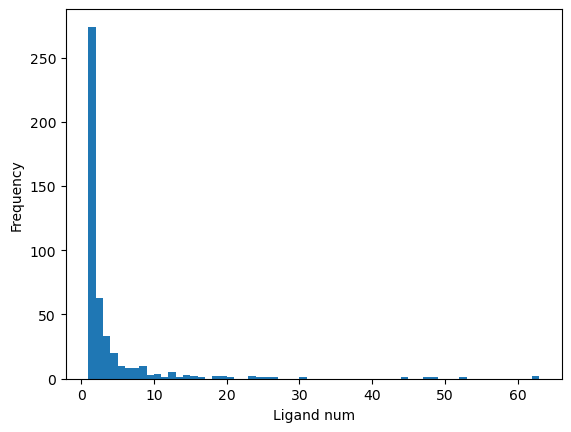

In [41]:
target_ligands_num = [len(l) for l in scaffolds.values()]
f = plt.hist(target_ligands_num, bins=62)
plt.xlabel('Ligand num')
plt.ylabel('Frequency')

In [42]:
import pickle
test_dict_path = r'D:\jiaxianyan\soft\github\UltraFlow\UltraFlow\data\horizontal_test.pkl'
with open(test_dict_path, 'rb') as f:
    test_dict = pickle.load(f)

In [45]:
test_dict[list(test_dict.keys())[0]]

[13, 14, 15, 16, 17, 18, 19, 40]

In [55]:
lig_path_sdf = r'D:\jiaxianyan\soft\github\UltraFlow\UltraFlow\data\chembl\P49841\visualize_dir\total_vs.sdf'
m_ligs = pybel.readfile('sdf', lig_path_sdf)

In [50]:
test_m = []
for i, m in enumerate(m_ligs):
    if i in test_dict[list(test_dict.keys())[0]]:
        test_m.append(m)

In [52]:
import oddt
def is_molecule(obj):
    """Check whether an object is an `oddt.toolkits.{rdk,ob}.Molecule` instance.

    .. versionadded:: 0.6
    """
    return is_openbabel_molecule(obj) or is_rdkit_molecule(obj)


def is_openbabel_molecule(obj):
    """Check whether an object is an `oddt.toolkits.ob.Molecule` instance.

    .. versionadded:: 0.6
    """
    return (hasattr(oddt.toolkits, 'ob') and
            isinstance(obj, oddt.toolkits.ob.Molecule))


def is_rdkit_molecule(obj):
    """Check whether an object is an `oddt.toolkits.rdk.Molecule` instance.

    .. versionadded:: 0.6
    """
    return (hasattr(oddt.toolkits, 'rdk') and
            isinstance(obj, oddt.toolkits.rdk.Molecule))

In [59]:
is_molecule(m_ligs)

False

In [57]:
test_m[0].atom_dict

AttributeError: 'Molecule' object has no attribute 'atom_dict'

In [58]:
m_ligs.atom_dict

AttributeError: 'generator' object has no attribute 'atom_dict'

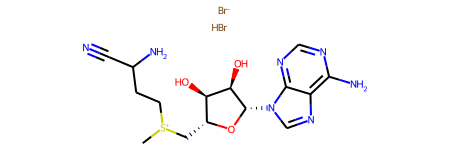

In [129]:
smi = 'Br.C[S+](CCC(N)C#N)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.[Br-]'
m = Chem.MolFromSmiles(smi, sanitize=True)
mw = Chem.RWMol(m)
mw

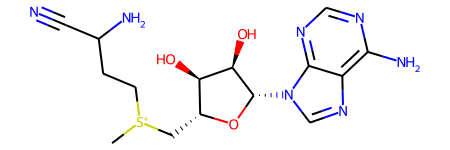

In [130]:
from rdkit.Chem import GetMolFrags
from rdkit.Chem.Draw import MolsToGridImage
import numpy as np
frags = GetMolFrags(mw, asMols=True)
frag_size = [len(frag.GetAtoms()) for frag in frags]
max_frag_index = np.argmax(frag_size)
max_frag = frags[max_frag_index]
max_frag

In [131]:
smi_new = Chem.MolToSmiles(max_frag)
smi_new

'C[S+](CCC(N)C#N)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O'

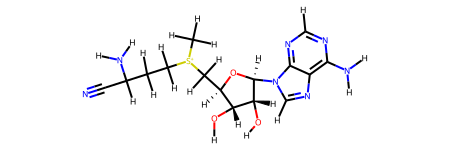

In [135]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol
max_frag = Chem.AddHs(max_frag)
neutralize_atoms(max_frag)
max_frag

In [136]:
print(Chem.MolToSmiles(max_frag))

[H]O[C@]1([H])[C@@]([H])(C([H])([H])[S+](C([H])([H])[H])C([H])([H])C([H])([H])C([H])(C#N)N([H])[H])O[C@@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]


In [137]:
Chem.GetFormalCharge(max_frag)

1